### Underdamped Langevin Adaptive

Simulate the dynamics of 

$$
dx = F(x) dt + \sqrt{2 \tau} dW(t)
$$

using the modified sde : 
$$
dy = F(y) ds+ g'(y) ds + \sqrt{2 \tau g(y)} dW(s)
$$

We use the system already extensively studied: 

$$
F(x)=-\nabla V(x) \\
V(x)= \frac{1}{2 x^2} +x^2\\
-\nabla V(x) = -\frac{1}{x^3}+2x
$$

### Try an adaptive stepsize that is easy to control: 

We can try 
$$
   f(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) \left(1-\exp(- x R) \right)+ \Delta t_{\text{min}},
$$
with 
$$
   f'(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R \exp(- x R).
$$
This is one example that is typically not based on the geometry of the problem but rather making the step smaller near the well of the potential. Alternatively, we could imagine a linear growth with a minimal value: 
$$
   f(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R x+ \Delta t_{\text{min}},
$$
$$
   f'(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R 
$$

Below, I plot those two examples of step sizes. 



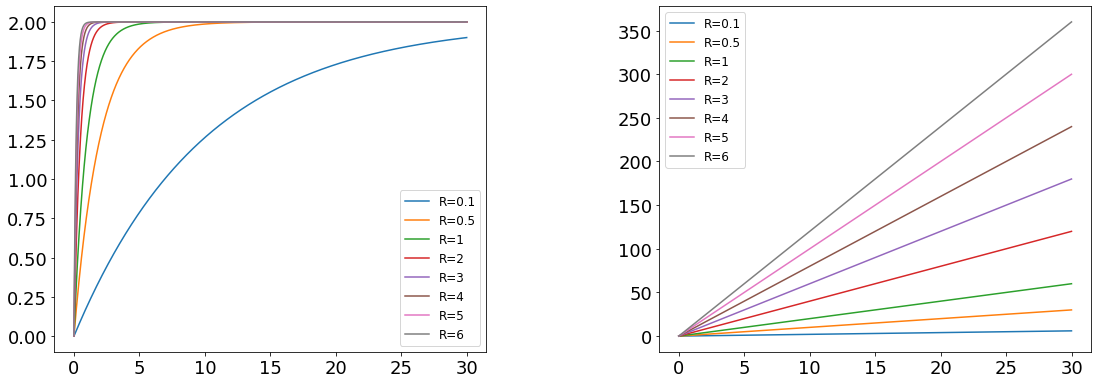

In [60]:
## Define step size functions
def var_stepsize1(x,dtmin, dtmax,R):
    return (dtmax-dtmin)*(np.abs(x))*R+dtmin

def var_stepsize2(x,dtmin, dtmax, R):
    return (dtmax-dtmin)*(1-np.exp(-np.abs(x)*R))+dtmin


# Plot the fimction of the 
fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(18,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9, top=0.9, wspace=0.4, hspace=0.4)

x=np.arange(0.0001,30,0.01)
Rrange=[0.1,0.5,1,2,3,4,5,6] # different values of the parameter R 
for ri in Rrange:
    ax1.plot(x,var_stepsize2(x,0.0001, 2, ri),label="R="+str(ri))
    ax2.plot(x,var_stepsize1(x,0.0001, 2,ri),label="R="+str(ri))
ax1.legend()
ax2.legend()

Ultimately we would like to use the geometry of the problem, such as using the absolute value of $ \|-\nabla V(x)\| = \| -\frac{1}{x^3}+2x\|$. 
The idea is to use 
$$ g(x) = \frac{1}{\|-\nabla V(x)\|} \\ 
g(x) = \frac{1}{ \|-\frac{1}{x^3}+2x\| }$$
and 
$$ g'(x) =\frac{- \|\frac{3}{x^4}+2\|}{\|-\frac{1}{x^3}+2x\|^2} $$


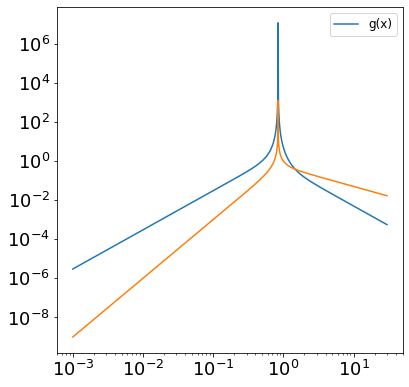

In [76]:
def g(x):
    """
    Compute the value of the adaptive function choosen:
    x: float 
    """
    x3=np.power(x,3)
    nablaV=np.abs(-1/x3+2*x)
    laplacienV=np.abs(3/(x3*x)+2)
    gx = 1/nablaV
    gprime=gx*laplacienV/nablaV
    re=np.array([gx,gprime])
    return re

fig, (ax1)= plt.subplots(1, 1,figsize=(6,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9, top=0.9, wspace=0.4, hspace=0.4)

x=np.arange(0.001,30,0.01)
ax1.loglog(x,g(x)[1,::],label="g(x)")
ax1.loglog(x,g(x)[0,::],label="")
ax1.legend()


We set up 3 files with the three different functions we discussed above; 
1. "infinitedoublewell_adaptive_gx1" uses $g(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) \left(1-\exp(- x R) \right)+ \Delta t_{\text{min}}$
2. "infinitedoublewell_adaptive_gx2" uses $g(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R x+ \Delta t_{\text{min}}$
3. "infinitedoublewell_adaptive_gx3" uses $g(x) = \frac{1}{\|-\nabla V(x)\|}$.

In [86]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_adaptivegx1.py"
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_adaptivegx2.py"
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_adaptivegx3.py"

%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_nsample.py"


<Figure size 432x288 with 0 Axes>

Fistlty we need to make a quick visual check to make sure that each adaptive method seems to be converging towards the actual method of interest. 

In [87]:
%time ytest= IDW_nsample_ada1(n_samples,T,dt,tau) # compile the function
%time ytest= IDW_nsample_ada2(n_samples,T,dt,tau)  # compile the function
%time ytest= IDW_nsample_ada3(n_samples,T,dt,tau)  # compile the function

CPU times: user 25.6 s, sys: 15.6 ms, total: 25.6 s
Wall time: 2.35 s
CPU times: user 25.7 s, sys: 11.9 ms, total: 25.7 s
Wall time: 2.38 s
CPU times: user 26.2 s, sys: 15.9 ms, total: 26.2 s
Wall time: 2.35 s


In [88]:
n_samples=10**4
T=10
dt=0.01
tau=1
# run non adaptive stepsize
y_nonada= IDW_nsample(n_samples,T,dt,tau) 
y_adag1= IDW_nsample_ada1(n_samples,T,dt,tau) 
y_adag2= IDW_nsample_ada2(n_samples,T,dt,tau) 
y_adag3= IDW_nsample_ada3(n_samples,T,dt,tau) 

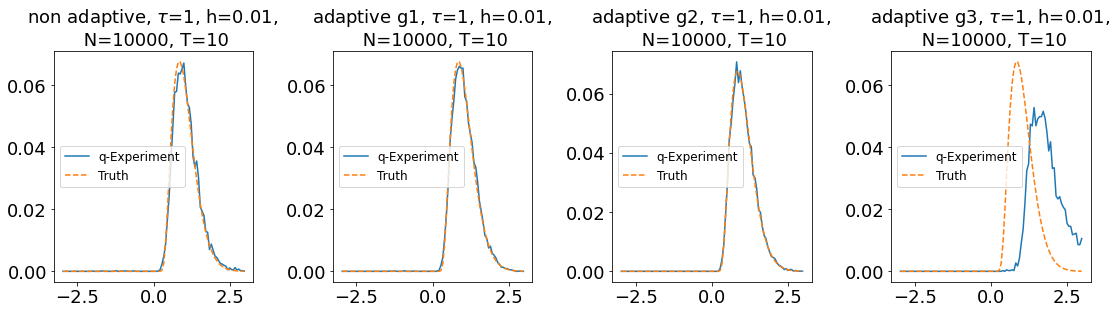

In [89]:
fig, (ax1,ax2,ax3,ax4)= plt.subplots(1,4,figsize=(18,4))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plot_dist(y_nonada,tau,dt,n_samples,T,"non adaptive",ax1)
plot_dist(y_adag1,tau,dt,n_samples,T,"adaptive g1",ax2)
plot_dist(y_adag2,tau,dt,n_samples,T,"adaptive g2",ax3)
plot_dist(y_adag3,tau,dt,n_samples,T,"adaptive g3",ax4)


It seems that the distribution are consistent, interestingly, we would like to have some values of the observable and compare the results.

#### compute escaping trajectories using usual step size 

In [27]:
def nesc_eta_dtlist(n_samples,dt_var,tau,T,b):
    """
    Function to establish the proportion of escaping trajectories
    Input :
    ------
    n_samples: int
        number of samples generated
    dt: float
        Time increment
    list_var: list of float
        list of values of the temperature to evaluate 
    T: int
        Final time until the solution is ran
    b: int
        Boundary selected
    """
    # empty vector to save results
    y_res = np.zeros((len(dt_var),n_samples))
    #list of escaping trajectories
    nesc_list=[]
    #run through the different values of tau 
    for i in range(len(dt_var)):
        dt_i=dt_var[i]
        y_exact = IDW_nsample(n_samples,T,dt_i,tau)
        y_res[i,::]=y_exact

        #compute the proportion of escaping trajectory
        res = len(y_exact[y_exact<0])+len(y_exact[y_exact>b])
        res = res/len(y_exact)
        nesc_list.append(res)
        
    return(nesc_list,y_res)

In [29]:
n_samples=10**5
tau=0.15
b1=0.05
b2=0.4
inc=(b2-b1)/10
dtlist3=np.arange(b1,b2+inc,inc)
T=100
b=10
nesc3, y_res3 = nesc_eta_dtlist(n_samples,dtlist3,tau,T,b)

In [41]:
def nesc_eta_dtlist_ada(n_samples,dt_var,tau,T,b):
    """
    Function to establish the proportion of escaping trajectories
    Input :
    ------
    n_samples: int
        number of samples generated
    dt: float
        Time increment
    list_var: list of float
        list of values of the temperature to evaluate 
    T: int
        Final time until the solution is ran
    b: int
        Boundary selected
    """
    # empty vector to save results
    y_res = np.zeros((len(dt_var),n_samples))
    #list of escaping trajectories
    nesc_list=[]
    #run through the different values of tau 
    for i in range(len(dt_var)):
        dt_i=dt_var[i]
        y_exact = IDW_nsample_ada(n_samples,T,dt_i,tau)
        y_res[i,::]=y_exact

        #compute the proportion of escaping trajectory
        res = len(y_exact[y_exact<0])+len(y_exact[y_exact>b])
        res = res/len(y_exact)
        nesc_list.append(res)
        
    return(nesc_list,y_res)

In [38]:
n_samples=10**5
tau=0.15
b1=0.05
b2=0.4
inc=(b2-b1)/10
dtlist3=np.arange(b1,b2+inc,inc)
T=100
b=10
nesc4, y_res4 = nesc_eta_dtlist_ada(n_samples,dtlist3,tau,T,b)

In [42]:
n_samples=10**5
tau=0.15
b1=0.05
b2=0.4
inc=(b2-b1)/10
dtlist3=np.arange(b1,b2+inc,inc)
T=100
b=10
nesc5, y_res5 = nesc_eta_dtlist_ada(n_samples,dtlist3,tau,T,b)

In [44]:
dtlist3

array([0.05 , 0.085, 0.12 , 0.155, 0.19 , 0.225, 0.26 , 0.295, 0.33 ,
       0.365, 0.4  ])

Text(0.5, 1.0, '$T=100$, $n_{samples}=10^5$')

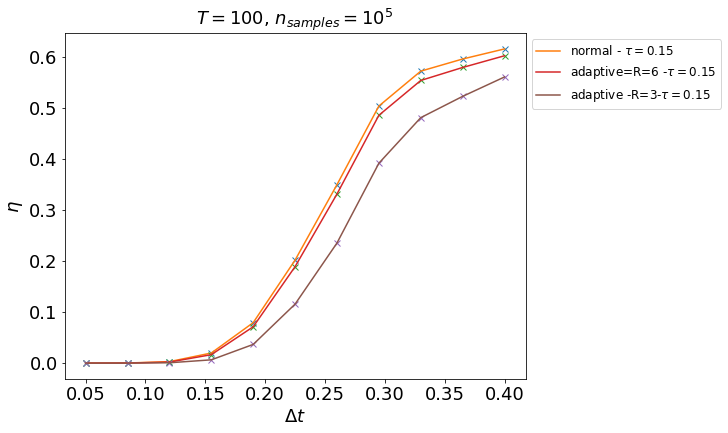

In [43]:
fig, (ax)= plt.subplots(1, 1,figsize=(8,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

ax.plot(dtlist3,nesc3,"x")
ax.plot(dtlist3,nesc3,label="normal - $\\tau=0.15$")
ax.plot(dtlist3,nesc4,"x")
ax.plot(dtlist3,nesc4,label="adaptive=R=6 -$\\tau=0.15$")
ax.plot(dtlist3,nesc5,"x")
ax.plot(dtlist3,nesc5,label="adaptive -R=3-$\\tau=0.15$")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
ax.set_ylabel("$\eta $")
ax.set_xlabel("$\Delta t $")
ax.set_title("$T=100$, $n_{samples}=10^5$")

### Plot distribution to make sure we get similar results 
    

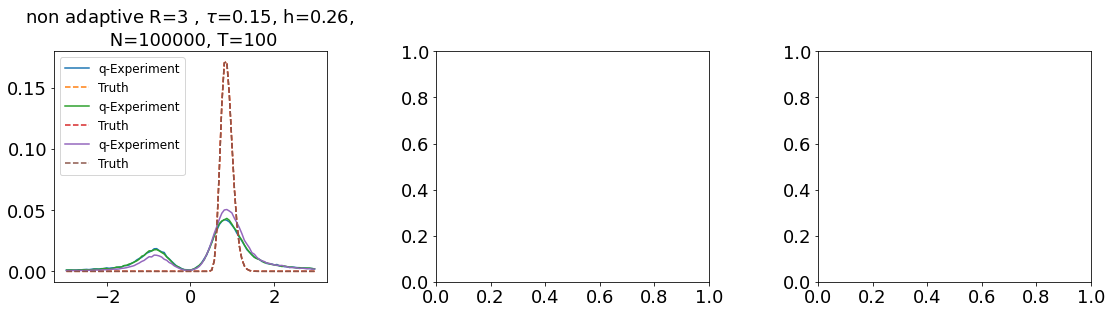

In [51]:
fig, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(18,4))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
i=6
tau=0.15
dt=dtlist3[i]
plot_dist(y_res3[i,::],0.15,dt,n_samples,T,"non adaptive ",ax1)
plot_dist(y_res4[i,::],tau,dt,n_samples,T,"adaptive R=6 ",ax1)
plot_dist(y_res5[i,::],tau,dt,n_samples,T,"non adaptive R=3 ",ax1)